In [9]:
import os
import random
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import img_to_array
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


### Generate Density Maps

In [10]:
def generate_density_map(img_path, mat_path, output_shape):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    ann = loadmat(mat_path)
    points = ann["annPoints"]  # shape (N, 2)
    density_map = np.zeros((h, w), dtype=np.float32)

    for point in points:
        x, y = int(point[0]), int(point[1])
        if x >= w or y >= h:
            continue
        density_map[y, x] = 1

    density_map = gaussian_filter(density_map, sigma=15)
    density_map = cv2.resize(density_map, output_shape)
    return density_map


### Image annotation path matching

In [ ]:
def get_img_and_mat_paths(root):
    img_paths, mat_paths = [], []
    for fname in os.listdir(root):
        if fname.endswith(".jpg"):
            img_path = os.path.join(root, fname)
            mat_name = fname.replace(".jpg", "_ann.mat")
            mat_path = os.path.join(root, mat_name)
            if os.path.exists(mat_path):
                img_paths.append(img_path)
                mat_paths.append(mat_path)
    return sorted(img_paths), sorted(mat_paths)

train_img_paths, train_mat_paths = get_img_and_mat_paths("UCF-QNRF_ECCV18/Train")
test_img_paths, test_mat_paths = get_img_and_mat_paths("UCF-QNRF_ECCV18/Test")


### Prepare Dataset

In [13]:
img_size = (320, 320)
batch_size = 4

def get_dataset(img_paths, mat_paths, batch_size, img_size):
    def load_img_and_density(img_path, mat_path):
        img = tf_io.read_file(img_path)
        img = tf_io.decode_jpeg(img, channels=3)
        img = tf_image.resize(img, img_size)
        img = tf_image.convert_image_dtype(img, tf.float32)

        def _load_density_map(py_img_path, py_mat_path):
            img_path_str = py_img_path.numpy().decode()
            mat_path_str = py_mat_path.numpy().decode()
            density = generate_density_map(img_path_str, mat_path_str, img_size)
            density = np.expand_dims(density, axis=-1)
            return density.astype(np.float32)

        density = tf.py_function(_load_density_map, [img_path, mat_path], tf.float32)
        density.set_shape([img_size[0], img_size[1], 1])
        return img, density

    dataset = tf_data.Dataset.from_tensor_slices((img_paths, mat_paths))
    dataset = dataset.map(load_img_and_density, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE)


### Define U-Net for Regression

In [14]:
def build_unet(input_shape):
    inputs = keras.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        p = layers.MaxPooling2D(2)(x)
        return x, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b = conv_block(p4, 1024)

    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, activation="linear")(d4)
    return Model(inputs, outputs)

model = build_unet((img_size[0], img_size[1], 3))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 320, 320,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 320, 320,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 160, 160,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 160, 160,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 160, 160,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 80, 80,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 80, 80,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 80, 80,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 40, 40,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 40,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 40, 40,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 20, 20,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 20, 20,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 20, 20,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 40, 40,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 40, 40,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [15]:
train_dataset = get_dataset(train_img_paths, train_mat_paths, batch_size, img_size)
val_dataset = get_dataset(test_img_paths, test_mat_paths, batch_size, img_size)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=2
)


Epoch 1/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 386s - 1s/step - loss: 2.7477 - mae: 0.8769 - val_loss: 0.4396 - val_mae: 0.4583
Epoch 2/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 342s - 1s/step - loss: 0.2765 - mae: 0.3580 - val_loss: 0.2005 - val_mae: 0.2997
Epoch 3/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 365s - 1s/step - loss: 0.1617 - mae: 0.2741 - val_loss: 0.1334 - val_mae: 0.2466
Epoch 4/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 365s - 1s/step - loss: 0.1138 - mae: 0.2304 - val_loss: 0.0953 - val_mae: 0.2107
Epoch 5/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 306s - 1s/step - loss: 0.0957 - mae: 0.2101 - val_loss: 0.0780 - val_mae: 0.1912
Epoch 6/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 323s - 1s/step - loss: 0.0784 - mae: 0.1919 - val_loss: 0.0612 - val_mae: 0.1674
Epoch 7/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 348s - 1s/step - loss: 0.0553 - mae: 0.1599 - val_loss: 0.0469 - val_mae: 0.1428
Epoch 8/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 342s - 1s/step - loss: 0.0837 - mae: 0.1881 - val_loss: 0.0412 - val_mae: 0.1346
Epoch 9/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 353s - 1s/step - loss: 0.0454 - mae: 0.1439 - val_loss: 0.0416 - val_mae: 0.1450
Epoch 10/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 343s - 1s/step - loss: 0.0432 - mae: 0.1411 - val_loss: 0.0508 - val_mae: 0.1709
Epoch 11/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 331s - 1s/step - loss: 0.0289 - mae: 0.1155 - val_loss: 0.0270 - val_mae: 0.1095
Epoch 12/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 315s - 1s/step - loss: 0.0458 - mae: 0.1343 - val_loss: 0.0243 - val_mae: 0.1039
Epoch 13/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 335s - 1s/step - loss: 0.0342 - mae: 0.1205 - val_loss: 0.0215 - val_mae: 0.0980
Epoch 14/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 324s - 1s/step - loss: 0.0325 - mae: 0.1217 - val_loss: 0.0263 - val_mae: 0.1223
Epoch 15/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 327s - 1s/step - loss: 0.0201 - mae: 0.0970 - val_loss: 0.0268 - val_mae: 0.1171
Epoch 16/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 351s - 1s/step - loss: 0.0335 - mae: 0.1098 - val_loss: 0.0193 - val_mae: 0.1034
Epoch 17/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 351s - 1s/step - loss: 0.0174 - mae: 0.0895 - val_loss: 0.0299 - val_mae: 0.1359
Epoch 18/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 349s - 1s/step - loss: 0.0197 - mae: 0.0923 - val_loss: 0.0239 - val_mae: 0.1161
Epoch 19/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 337s - 1s/step - loss: 0.0187 - mae: 0.0898 - val_loss: 0.0190 - val_mae: 0.1048
Epoch 20/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 340s - 1s/step - loss: 0.0185 - mae: 0.0855 - val_loss: 0.0172 - val_mae: 0.0968
Epoch 21/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 365s - 1s/step - loss: 0.0115 - mae: 0.0699 - val_loss: 0.0105 - val_mae: 0.0758
Epoch 22/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 356s - 1s/step - loss: 0.0090 - mae: 0.0661 - val_loss: 0.0195 - val_mae: 0.1113
Epoch 23/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 320s - 1s/step - loss: 0.0130 - mae: 0.0768 - val_loss: 0.0387 - val_mae: 0.1678
Epoch 24/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 335s - 1s/step - loss: 0.0102 - mae: 0.0671 - val_loss: 0.0160 - val_mae: 0.1006
Epoch 25/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 342s - 1s/step - loss: 0.0128 - mae: 0.0702 - val_loss: 0.0080 - val_mae: 0.0677
Epoch 26/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 347s - 1s/step - loss: 0.0077 - mae: 0.0599 - val_loss: 0.0050 - val_mae: 0.0459
Epoch 27/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 353s - 1s/step - loss: 0.0071 - mae: 0.0572 - val_loss: 0.0088 - val_mae: 0.0739
Epoch 28/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 347s - 1s/step - loss: 0.0063 - mae: 0.0527 - val_loss: 0.0084 - val_mae: 0.0709
Epoch 29/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 354s - 1s/step - loss: 0.0075 - mae: 0.0567 - val_loss: 0.0184 - val_mae: 0.1146
Epoch 30/30


Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 351s - 1s/step - loss: 0.0055 - mae: 0.0496 - val_loss: 0.0029 - val_mae: 0.0373


### Plot Training Curves

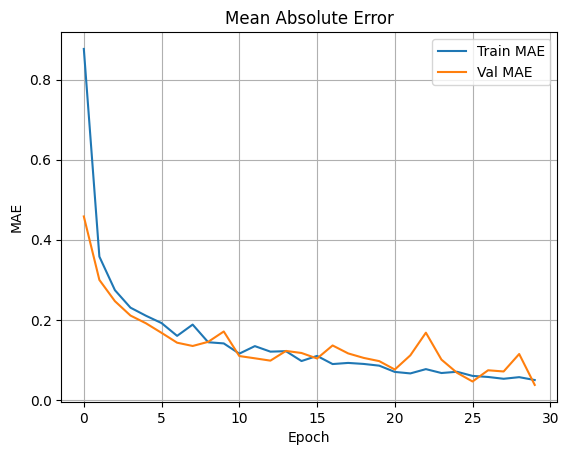

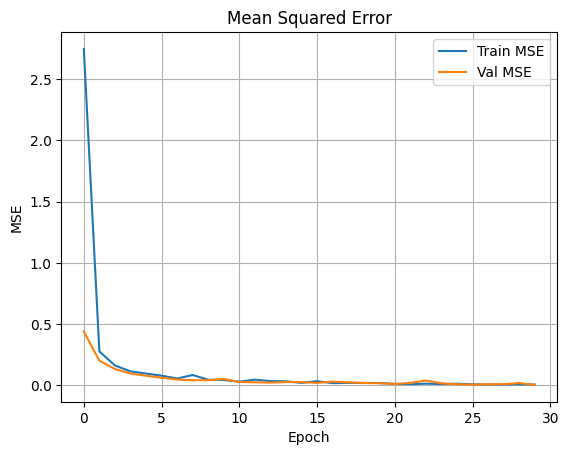

In [16]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.title("Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()


### Visualize Predictions and Count People

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


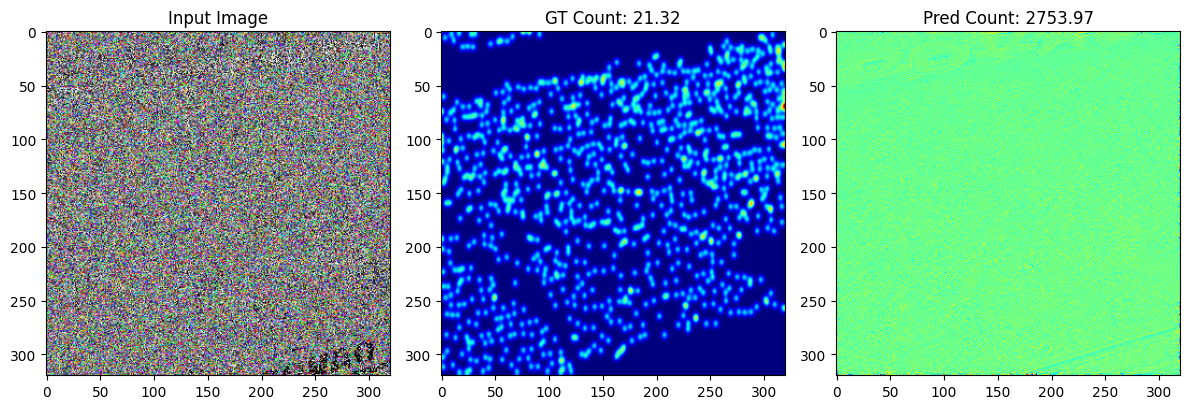

In [19]:
def visualize_prediction(index):
    test_imgs, test_density = next(iter(val_dataset))
    
    # Convert Tensor to NumPy array for display
    img = test_imgs[index].numpy()
    img = (img * 255).astype(np.uint8)

    true_density = test_density[index].numpy()
    pred_density = model.predict(tf.expand_dims(test_imgs[index], axis=0))[0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(true_density), cmap='jet')
    plt.title(f"GT Count: {np.sum(true_density):.2f}")

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_density), cmap='jet')
    plt.title(f"Pred Count: {np.sum(pred_density):.2f}")

    plt.tight_layout()
    plt.show()

visualize_prediction(0)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


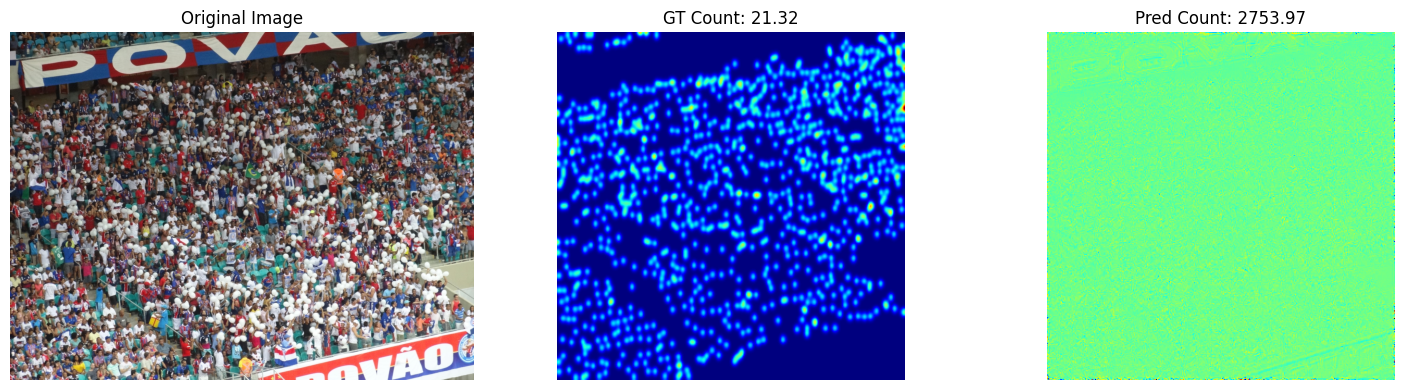

In [25]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualize_prediction(index):
    # Load original image from file (before resizing or normalization)
    orig_img_path = test_img_paths[index]
    orig_img = cv2.imread(orig_img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Get preprocessed image and density map from dataset
    test_imgs, test_density = next(iter(val_dataset))  # small batch
    true_density = test_density[index].numpy()
    pred_density = model.predict(tf.expand_dims(test_imgs[index], axis=0))[0]

    plt.figure(figsize=(15, 4))

    # Show original image (unmodified)
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    # Show ground-truth density map
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(true_density), cmap='jet')
    plt.title(f"GT Count: {np.sum(true_density):.2f}")
    plt.axis("off")

    # Show predicted density map
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_density), cmap='jet')
    plt.title(f"Pred Count: {np.sum(pred_density):.2f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_prediction(0)    
